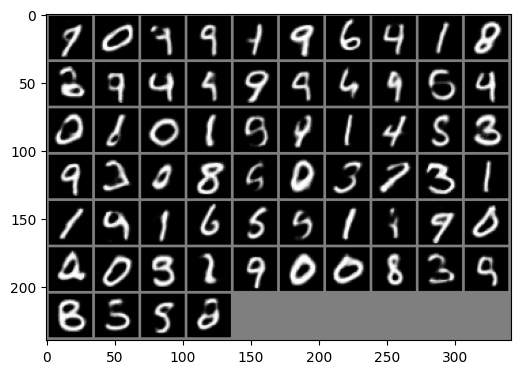

[Epoch 52/200] [Batch 425/938] [D loss: 0.069206] [G loss: 0.051166] -- M: 0.078396, k: 0.094395
[Epoch 52/200] [Batch 426/938] [D loss: 0.065645] [G loss: 0.057120] -- M: 0.074879, k: 0.094391
[Epoch 52/200] [Batch 427/938] [D loss: 0.080744] [G loss: 0.054816] -- M: 0.095541, k: 0.094400
[Epoch 52/200] [Batch 428/938] [D loss: 0.067384] [G loss: 0.051866] -- M: 0.074624, k: 0.094403
[Epoch 52/200] [Batch 429/938] [D loss: 0.071346] [G loss: 0.056403] -- M: 0.077771, k: 0.094404
[Epoch 52/200] [Batch 430/938] [D loss: 0.070856] [G loss: 0.055315] -- M: 0.077822, k: 0.094406
[Epoch 52/200] [Batch 431/938] [D loss: 0.067015] [G loss: 0.056596] -- M: 0.074685, k: 0.094403
[Epoch 52/200] [Batch 432/938] [D loss: 0.071397] [G loss: 0.054804] -- M: 0.079194, k: 0.094406
[Epoch 52/200] [Batch 433/938] [D loss: 0.070143] [G loss: 0.051684] -- M: 0.079605, k: 0.094410
[Epoch 52/200] [Batch 434/938] [D loss: 0.069922] [G loss: 0.054625] -- M: 0.076763, k: 0.094412
[Epoch 52/200] [Batch 435/938]

KeyboardInterrupt: 

In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=62, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="number of image channels")
opt = parser.parse_args([])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Upsampling
        self.down = nn.Sequential(nn.Conv2d(opt.channels, 64, 3, 2, 1), nn.ReLU())
        # Fully-connected layers
        self.down_size = opt.img_size // 2
        down_dim = 64 * (opt.img_size // 2) ** 2
        self.fc = nn.Sequential(
            nn.Linear(down_dim, 32),
            nn.BatchNorm1d(32, 0.8),
            nn.ReLU(inplace=True),
            nn.Linear(32, down_dim),
            nn.BatchNorm1d(down_dim),
            nn.ReLU(inplace=True),
        )
        # Upsampling
        self.up = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(64, opt.channels, 3, 1, 1))

    def forward(self, img):
        out = self.down(img)
        out = self.fc(out.view(out.size(0), -1))
        out = self.up(out.view(out.size(0), 64, self.down_size, self.down_size))
        return out


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

# BEGAN hyper parameters
gamma = 0.75
lambda_k = 0.001
k = 0.0

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = torch.mean(torch.abs(discriminator(gen_imgs) - gen_imgs))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        d_real = discriminator(real_imgs)
        d_fake = discriminator(gen_imgs.detach())

        d_loss_real = torch.mean(torch.abs(d_real - real_imgs))
        d_loss_fake = torch.mean(torch.abs(d_fake - gen_imgs.detach()))
        d_loss = d_loss_real - k * d_loss_fake
        
        d_loss.backward()
        optimizer_D.step()

        # ----------------
        # Update weights
        # ----------------

        diff = torch.mean(gamma * d_loss_real - d_loss_fake)

        # Update weight term for fake samples
        k = k + lambda_k * diff.item()
        k = min(max(k, 0), 1)  # Constraint to interval [0, 1]

        # Update convergence metric
        M = (d_loss_real + torch.abs(diff))
        #print(M.shape)

        # --------------
        # Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] -- M: %f, k: %f"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item(), M, k)
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            clear_output()
            show(gen_imgs)
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
